### importation des librairies utiles et des données

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, learning_curve
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
import sys
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers,callbacks
from tensorflow.keras.utils import to_categorical

In [5]:
#from google.colab import drive
drive.mount('/content/drive')
customer = pd.read_csv("/content/drive/My Drive/Customer.csv", na_values=['?', 'unknown'])
population = pd.read_csv("/content/drive/My Drive/CountryPopulation.csv")
gdp = pd.read_csv("/content/drive/My Drive/CountryGDP.csv")

#Lorsque necessare, on fera la jointure des 3 bases de données
def joindre_database(db1, db2, cle_jointure):
    db1.columns = [col.lower() for col in db1.columns]
    db2.columns = [col.lower() for col in db2.columns]
    db = pd.merge(db1, db2, on=cle_jointure.lower(), how='inner')
    return db

#db = joindre_database(customer, population, 'Country')
#df = joindre_database(db, gdp, 'Country')
df = customer
df.head()

Mounted at /content/drive


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0


### Préparation du pipeline pour traiter les données

In [6]:
def convertir_binaire(data ,  colonne):
  data = data.copy()
  data['revenue_bin'] = np.where(data[colonne] > np.mean(data[colonne]), 1, 0)
  return data
df_bin  = convertir_binaire(df, 'revenue')
df_bin.head()


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue,revenue_bin
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0,0
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0,0
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0,0
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0,0
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0,0


In [7]:
seed = 2025
train_set_bin, test_set_bin = train_test_split(df_bin, test_size=0.2,  random_state=seed)
X_train_bin = train_set_bin.drop(columns = ["revenue_bin","revenue"], axis=1)
Y_train_bin = train_set_bin["revenue_bin"]
X_test_bin = test_set_bin.drop(columns=["revenue_bin","revenue"], axis = 1)
Y_test_bin = test_set_bin["revenue_bin"]

In [8]:
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    Q25 = df.quantile(0.25)
    Q75 = df.quantile(0.75)
    IQR = Q75 - Q25
    SeuilMin = Q25 - 1.5 * IQR
    SeuilMax = Q75 + 1.5 * IQR
    return df.clip(SeuilMin, SeuilMax, axis=1)

def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

#### Fonction de conversion en numérique
def toNum(data: pd.DataFrame):
    if 'first_item_prize' in data.columns:
        data['first_item_prize'] = pd.to_numeric(data['first_item_prize'], errors='coerce')
    return data

### Pipeline numérique
num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, feature_names_out='one-to-one')),  # Correction ici
    ('imputer', SimpleImputer(strategy="median")),
    ('clamp', FunctionTransformer(bornage, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

### Pipeline catégoriel
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Correction ici
])

### Pipeline complet
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

# Transformation des données
X_train_pret = pd.DataFrame(full_pipeline.fit_transform(X_train_bin))
X_test_pret = pd.DataFrame(full_pipeline.transform(X_test_bin))

### Question 2.1.1 : Entrainment du PMC pour le classeur binaire

In [14]:
param_grid = {
    'hidden_layer_sizes':
    [(n,) for n in range(10, 101, 10)] +
    [(n, n) for n in range(10, 101, 10)] +
    [(n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n, n) for n in range(10, 101, 10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'max_iter': [300, 400, 500]
}
gpus = tf.config.experimental.list_physical_devices('GPU')
mlp = MLPClassifier(random_state = seed)

random_search = RandomizedSearchCV(
    mlp, param_distributions=param_grid,
    cv=3, scoring='accuracy',
    n_jobs=-1, return_train_score=True
)

random_search.fit(X_train_pret, Y_train_bin)

best_params = random_search.best_params_
print(f"Meilleure architecture trouvée : {best_params['hidden_layer_sizes']}")
print(f"Couches cachées, activation={best_params['activation']}, max_iter={best_params['max_iter']}")
print(f"Meilleur score sur validation croisée : {random_search.best_score_:.4f}")

Y_pred = random_search.best_estimator_.predict(X_test_pret)
print("Accuracy sur le test set :", accuracy_score(Y_test_bin, Y_pred))


Meilleure architecture trouvée : (60, 60, 60, 60, 60)
Couches cachées, activation=logistic, max_iter=500
Meilleur score sur validation croisée : 0.8557
Accuracy sur le test set : 0.8595


La meilleure architechture trouvée est celle avec 5 couches de 60 neurones chacune.

In [15]:
#le meilleur modele est le suivant :
meilleur_modele_mpc = MLPClassifier(hidden_layer_sizes = (60,60,60,60,60),
                      activation='logistic',max_iter=500)
meilleur_modele_mpc.fit(X_train_pret,Y_train_bin)
print(f'accuracy = {round(meilleur_modele_mpc.score(X_test_pret, Y_test_bin),2)}')

accuracy = 0.86


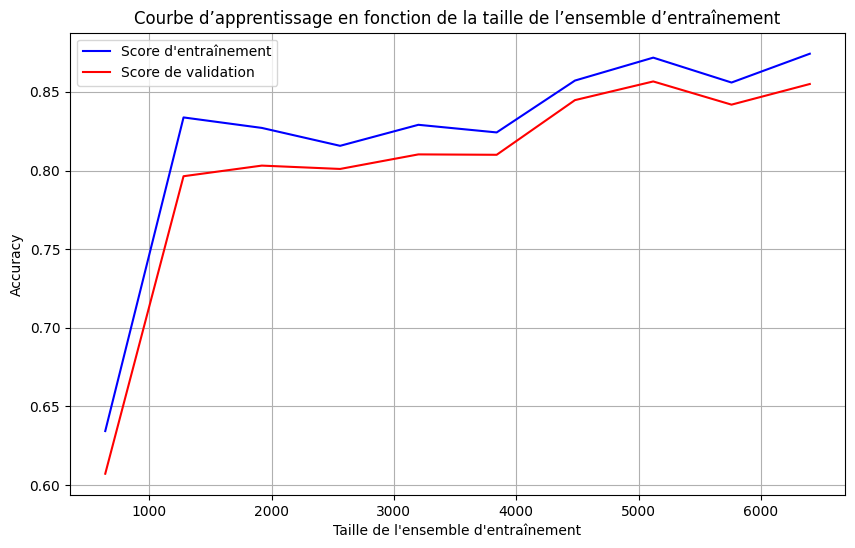

In [17]:
#On trace la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(
    random_search.best_estimator_,
    X_train_pret, Y_train_bin,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color="blue", label="Score d'entraînement")
plt.plot(train_sizes, val_mean, color="red", label="Score de validation")

plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.title("Courbe d’apprentissage en fonction de la taille de l’ensemble d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

### Question 2.1.2 : Entrainement du PMC pour un classeur trois classes

In [9]:
def classer3_classes(data, colonne):
    data = data.copy()
    q1 = data[colonne].quantile(0.25)
    q3 = data[colonne].quantile(0.75)

    data['revenue3'] = np.where(
        data[colonne] <= q1, 'bas',
        np.where(data[colonne] <= q3, 'moyen', 'eleve')
    )

    return data
df3 = classer3_classes(df, 'revenue')
df3.head()


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue,revenue3
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0,moyen
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0,bas
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0,moyen
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0,moyen
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0,moyen


In [11]:
train_set3, test_set3 = train_test_split(df3, test_size=0.2, random_state=seed)
X_train3 = train_set3.drop(columns=["revenue", "revenue3"], axis=1)
Y_train3 = train_set3["revenue3"]
X_test3 = test_set3.drop(columns=["revenue", "revenue3"], axis=1)
Y_test3 = test_set3["revenue3"]

full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

X_train_pret = pd.DataFrame(full_pipeline.fit_transform(X_train3))
X_test_pret = pd.DataFrame(full_pipeline.transform(X_test3))


gpus = tf.config.experimental.list_physical_devices('GPU')

#On entraine le perceptron
param_grid = {
    'hidden_layer_sizes':
    [(n,) for n in range(10, 101, 10)] +
    [(n, n) for n in range(10, 101, 10)] +
    [(n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n, n) for n in range(10, 101, 10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'max_iter': [10, 50, 100, 200, 300, 400, 500]
}

mlp = MLPClassifier(random_state = seed)

random_search = RandomizedSearchCV(
    mlp, param_distributions=param_grid,
    cv=3, scoring='accuracy',
    n_jobs=-1, return_train_score=True
)

random_search.fit(X_train_pret, Y_train3)

best_params = random_search.best_params_
print(f"Meilleure architecture trouvée : {best_params['hidden_layer_sizes']}")
print(f"Couches cachées, activation={best_params['activation']}, max_iter={best_params['max_iter']}")
print(f"Meilleur score sur validation croisée : {random_search.best_score_:.4f}")

Y_pred = random_search.best_estimator_.predict(X_test_pret)
print("Accuracy sur le test set :", accuracy_score(Y_test3, Y_pred))

Meilleure architecture trouvée : (60, 60, 60, 60)
Couches cachées, activation=logistic, max_iter=300
Meilleur score sur validation croisée : 0.7632
Accuracy sur le test set : 0.79


On constate que la meilleure architechture trouvée est celle avec 4 couches, comportant chacune 60 neurones.

In [13]:
#le meilleur modele est le suivant :
meilleur_modele_mpc = MLPClassifier(hidden_layer_sizes = (60,60,60,60),
                      activation='logistic',max_iter=500)
#J'ai augmenté le nombre d'iterations a 500 pour m'assurer de la convergence
meilleur_modele_mpc.fit(X_train_pret,Y_train3)
print(f'accuracy = {round(meilleur_modele_mpc.score(X_test_pret, Y_test3),2)}')

accuracy = 0.79


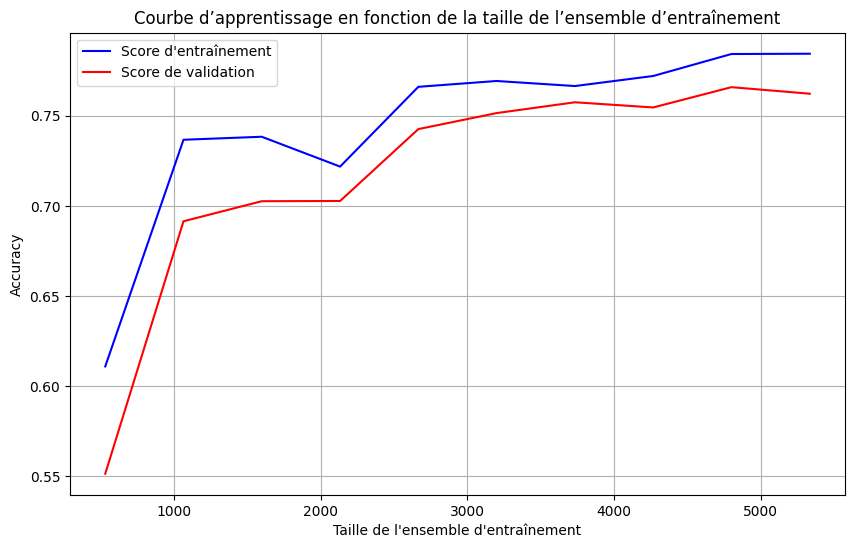

In [14]:
train_sizes, train_scores, val_scores = learning_curve(
    random_search.best_estimator_,
    X_train_pret, Y_train3,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean,  color="blue", label="Score d'entraînement")
plt.plot(train_sizes, val_mean,  color="red", label="Score de validation")

plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.title("Courbe d’apprentissage en fonction de la taille de l’ensemble d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

Les performences sont moins bonne que pour un classeur binaire. De plus  le modèle sur-ajuste aussi, surtout avec les dennées de petite taille. Lorsqu'on augmente la taille, le modèle s'améliore mais pas assez pour satisfaire.

Une solution peut être d'ajouter des observation ou  **d'enrichir les données**

### Question2.2.1 :
Cette section est simplement le copier-collé de ce qui a été fait en classe, je n'ai rien rajouté, sinon les commentaires. Les codes ne m'appartiennent pas.

Par contre, le code qui calcule le temps d'entrainement, je les pris sur stack overflows

Le code de la fonction qui convertit le temps a été écrit par  moi meme. Mais je me suis inspiré d'un exercice que j'ai fais dans le cours de programmation avec c++

In [55]:
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
np.random.seed(2025)
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [56]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
x_train_full.shape
#x_train_full.dtype

(60000, 28, 28)

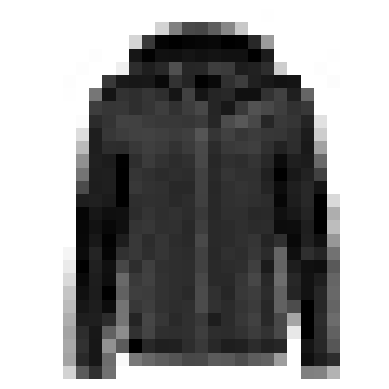

In [57]:
x_valid, x_train = x_train_full[:5000] / 255., x_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255.

plt.imshow(x_train[0], cmap="binary")
plt.axis('off')
plt.show()

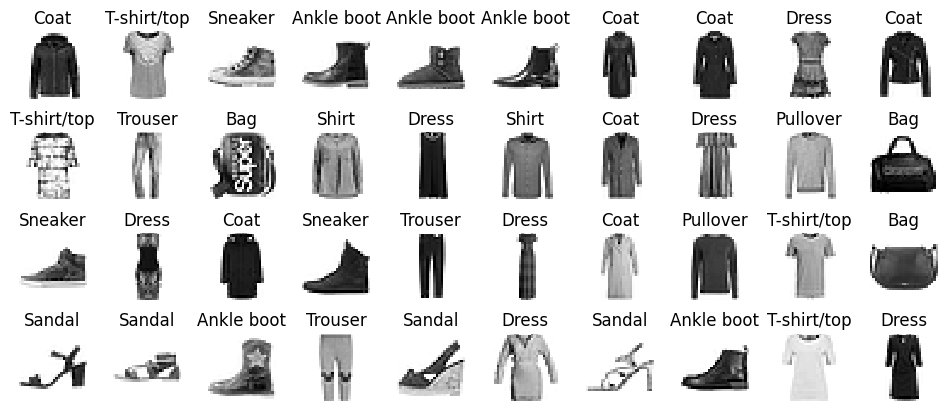

In [58]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Créons un modele PMC avec l'API Sequential.
1. La premiere ligne du code crée un modèle Sequential. C'est la maniere la plus simple de créer un RNA avec keras. Il est constitué d'une seule pile de couches connectées sous forme séquentielle.
2. Ensuite, nous ajoutons la couche Flatten-aplatissement- dans le but de convertir chaque image d'entrée en un tableau monodimensionnel
3. Ensuite nous ajoutons une couche cachée de 300 neurones. Elle utilise la fonction d'activation ReLU.
4. on ajoute une cachée Dense de 100 neurones, avec une fonction d'activation ReLU.
5. Enfin une couche de sortie Dense avec 10 neurones (un par classe) en utilisant la fonction d'activation softmax.

In [59]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
keras.backend.clear_session() # re-initialiser les états internes de tensorflow
np.random.seed(2025)
tf.random.set_seed(2025)
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def convertir_temps(temps):
    minute = temps // 60
    seconde = temps % 60
    heure = minute // 60
    minute = minute % 60

    if heure < 24:
        return f"{heure}h {minute}m {seconde}s"
    else:
        jour = heure // 24
        heure = heure % 24
        return f"{jour}j {heure}h {minute}m {seconde}s"


In [62]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
start = time.time()
history1 = model1.fit(x_train, y_train, epochs= 30,
                    validation_data=(x_valid, y_valid))
end = time.time()

print(f"Temps d'entraînement: {convertir_temps(int(end - start))}")


Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6941 - loss: 0.9669 - val_accuracy: 0.8306 - val_loss: 0.5092
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8244 - loss: 0.5066 - val_accuracy: 0.8466 - val_loss: 0.4486
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8415 - loss: 0.4543 - val_accuracy: 0.8558 - val_loss: 0.4205
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8519 - loss: 0.4245 - val_accuracy: 0.8634 - val_loss: 0.3985
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8597 - loss: 0.4027 - val_accuracy: 0.8684 - val_loss: 0.3840
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8656 - loss: 0.3859 - val_accuracy: 0.8720 - val_loss: 0.3732
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8701 - loss: 0.3720 - val_accuracy: 0.8754 - val_loss: 0.3642
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8735 - loss: 0.3598 - 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


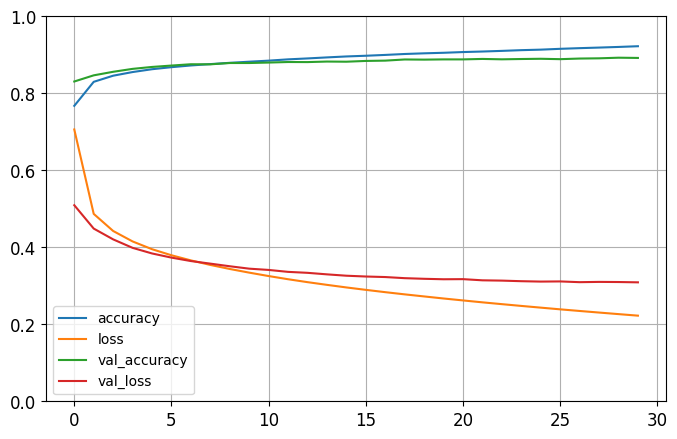

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.3435
score sur l ensemble test  = 0.88


In [64]:
print(history1.epoch)

pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(f'score sur l ensemble test  = { round(model1.evaluate(x_test, y_test)[1],2)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


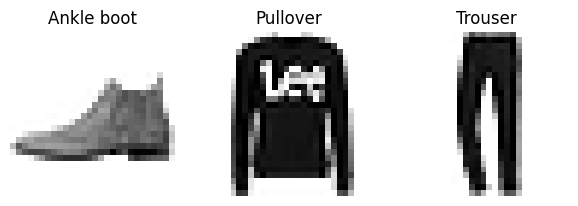

In [65]:
x_new = x_test[:3]
y_proba = model.predict(x_new)
y_proba.round(2)
y_pred = np.argmax(model.predict(x_new), axis=-1)
y_pred

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(x_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


### Question 2.2.2

Implantons un CNN dont on déterminera l'architechture qui doit améliorer la performance du modèle obtenu précédament

In [72]:
data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
# Define the CNN architecture
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
start_pmc = time.time()
history_cnn = model_cnn.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))
end_pmc = time.time()
print(f"Temps d'entraînement: {convertir_temps(int(end_pmc - start_pmc))}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6793 - loss: 0.8692 - val_accuracy: 0.8382 - val_loss: 0.4441
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8395 - loss: 0.4469 - val_accuracy: 0.8566 - val_loss: 0.3876
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8677 - loss: 0.3729 - val_accuracy: 0.8671 - val_loss: 0.3600
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8832 - loss: 0.3281 - val_accuracy: 0.8775 - val_loss: 0.3304
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8926 - loss: 0.2998 - val_accuracy: 0.8835 - val_loss: 0.3225
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9019 - loss: 0.2719 - val_accuracy: 0.8779 - val_loss: 0.3399
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9078 - loss: 0.2558 - val_accuracy: 0.8848 - val_loss: 0.3256
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9121 - loss: 0.2

### Question 2.2.3
Courbe d'apprentissage du CNN obtenu en 2.2.2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


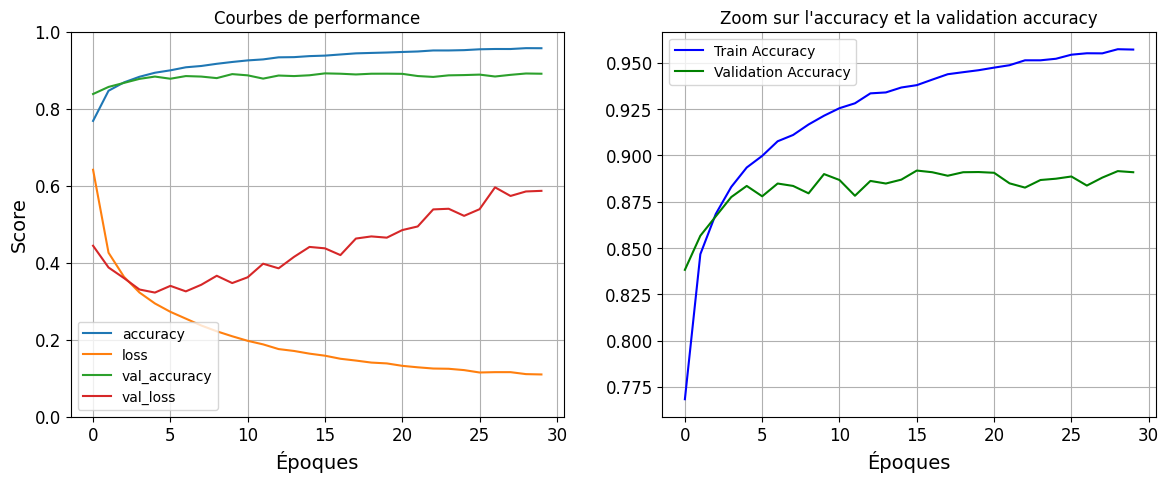

Score sur l'ensemble test = 0.89


In [73]:
def construire_courbe(history, model):
    print(history.epoch)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    pd.DataFrame(history.history).plot(ax=axes[0])
    axes[0].set_title("Courbes de performance")
    axes[0].set_xlabel('Époques')
    axes[0].set_ylabel('Score')
    axes[0].grid(True)
    axes[0].set_ylim(0, 1)

    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    axes[1].set_xlabel('Époques')
    axes[1].set_title("Zoom sur l'accuracy et la validation accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

    score_test = model.evaluate(x_test, y_test, verbose=0)[1]
    print(f'Score sur l\'ensemble test = {score_test:.2f}')
construire_courbe(history_cnn, model_cnn)

À partir de la courbe, On constate que le modèle CNN a légèrement amélioré le score, comparé au reseau des neurones profond. Bien qu'il est tout de même important de mentionner  qu'à cause de sa multitude de paramètres, il surajuste les données.
On devra donc penser à un enrichissement des données pour tenter de résoudre le problème de sur ajustement.

### Question 2.2.4 :
Entrainement du CNN obtenu en 2.2.2 en utilisant la technique d’augmentation des données à l’aide de l’outil « ImageDataGenerator » de Keras  (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/Image DataGenerator).  

In [78]:
image_aug = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.1,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
#On prend la meme architechture que précédament
model_cnn_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_cnn_aug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#print("GPU disponible :", tf.config.list_physical_devices('GPU'))

with tf.device('/GPU:0'):
  start_pmc_aug = time.time()
  history_cnn_aug = model_cnn_aug.fit(image_aug.flow(x_train, y_train, batch_size=32),
                        epochs=15, validation_data=(x_test, y_test))
  end_pmc_aug = time.time()
print(f"Temps d'entraînement: {convertir_temps(int(end_pmc_aug - start_pmc_aug))}")
#model_cnn_aug.evaluate(x_test, y_test)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.5610 - loss: 1.1776 - val_accuracy: 0.7631 - val_loss: 0.6071
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7509 - loss: 0.6748 - val_accuracy: 0.8143 - val_loss: 0.5087
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7817 - loss: 0.5883 - val_accuracy: 0.8208 - val_loss: 0.4728
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8037 - loss: 0.5368 - val_accuracy: 0.8423 - val_loss: 0.4307
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8164 - loss: 0.5041 - val_accuracy: 0.8509 - val_loss: 0.4144
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8245 - loss: 0.4787 - val_accuracy: 0.8578 - val_loss: 0.3886
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.8291 - loss: 0.4695 - val_accuracy: 0.8623 - val_loss: 0.3784
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8345 - loss: 0.45

Le fait que la performence ne varie pas est un bon signe. ça signifie que le modèle est robuste.

Visualisation de la courbe de performence

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


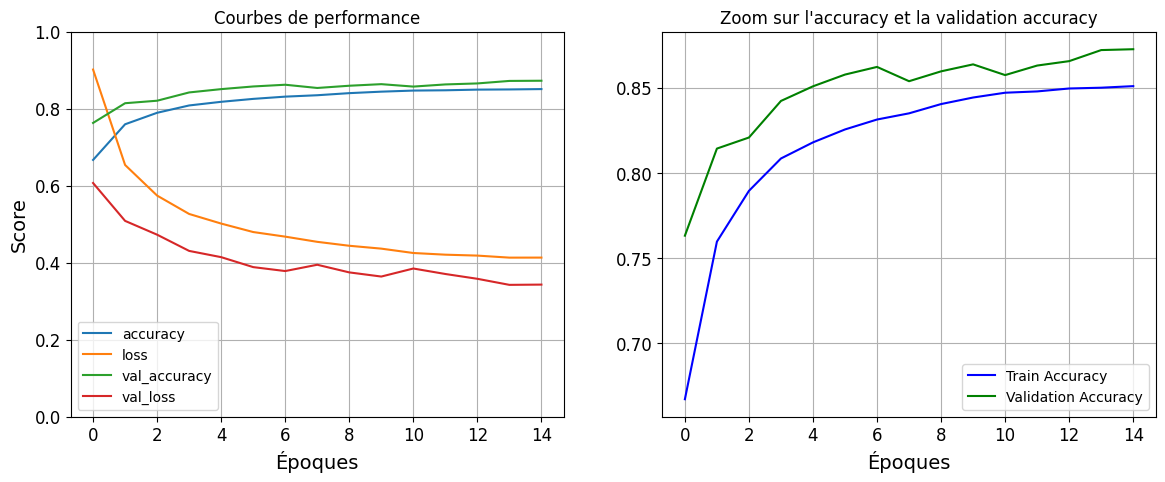

Score sur l'ensemble test = 0.87


In [80]:
construire_courbe(history_cnn_aug,model_cnn_aug)

Le score de validation a légèrement chutté, mais on remarque quand meme que le modèle ne surajuste plus comme précédament.

Il est tout de même important de reléver que les scores de validation sont légèrement suppérieurs aux scores d'entrainement, ce qui est normal, par ce qu'on a modifié le set d'entrainement lors de l'entrainement en faisant des rotations, des homothéties et des translations... En plus certains neurones ont été désactivés via la commande  Dropout(0.5) lors de l'entrainement, et ne le sont pas lors de la validation.

### Question 2.2.5
Utilisons  un modèle pré-entrainé (VGG16 ou un autre) cette fois  pour tenter d’augmenter la performance du CNN obtenu en 2.2.4
https://keras.io/api/applications/vgg/

In [7]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
conv_base.summary() #Pour consulter les détails du modèle en question

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()


x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#x_mean = x_train.mean(axis=0, keepdims=True)
#x_std = x_train.std(axis=0, keepdims=True) + 1e-7
#x_train = (x_train - x_mean) / x_std
#x_valid = (x_valid - x_mean) / x_std
#x_test = (x_test - x_mean) / x_std

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


In [9]:
model_vgg = models.Sequential()
model_vgg.add(conv_base)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.BatchNormalization())
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dropout(0.5))
model_vgg.add(layers.BatchNormalization())
model_vgg.add(layers.Dense(64, activation='relu'))
model_vgg.add(layers.Dropout(0.2))
model_vgg.add(layers.BatchNormalization())
model_vgg.add(layers.Dense(10, activation='softmax'))

model_vgg.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])


In [10]:
x_train = tf.expand_dims(x_train, -1)
x_valid = tf.expand_dims(x_valid, -1)

# Conversion en RGB : (28, 28, 1) -> (28, 28, 3)
x_train = tf.image.grayscale_to_rgb(x_train)
x_valid = tf.image.grayscale_to_rgb(x_valid)

# Redimensionnement : (28, 28, 3) -> (32, 32, 3)
x_train = tf.image.resize(x_train, [32, 32])
x_valid = tf.image.resize(x_valid, [32, 32])
x_train = x_train / 255.0
x_valid = x_valid / 255.0

checkpoint_cb = callbacks.ModelCheckpoint(
    "model_vgg_checkpoint.h5", save_best_only=True, monitor='val_accuracy'
)

with tf.device('/GPU:0'):
    start_vgg = time.time()
    history_vgg = model_vgg.fit(
        x_train, y_train,
        epochs= 10,
        batch_size=20,
        validation_data=(x_valid, y_valid),
        callbacks=[checkpoint_cb]
    )
    end_vgg = time.time()
print(f"Temps d'entraînement: {convertir_temps(int(end_vgg - start_vgg))}")

Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 89s 30ms/step - acc: 0.6227 - loss: 1.2099 - val_acc: 0.8922 - val_loss: 0.3615
Epoch 2/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 138s 30ms/step - acc: 0.8681 - loss: 0.5011 - val_acc: 0.9010 - val_loss: 0.2861
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - acc: 0.8938 - loss: 0.3990 - val_acc: 0.9162 - val_loss: 0.2600
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - acc: 0.9114 - loss: 0.3334 - val_acc: 0.9098 - val_loss: 0.2793
Epoch 5/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - acc: 0.9179 - loss: 0.3019 - val_acc: 0.9206 - val_loss: 0.2419
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - acc: 0.9262 - loss: 0.2704 - val_acc: 0.9234 - val_loss: 0.2333
Epoch 7/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - acc: 0.9312 - loss: 0.2552 - val_acc: 0.9196 - val_loss: 0.2549
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - acc: 0.9379 - loss: 0.2252 - val_acc: 0.9340 - val_loss: 0.2107
Epoch 9/10
2750/2750 ━━

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


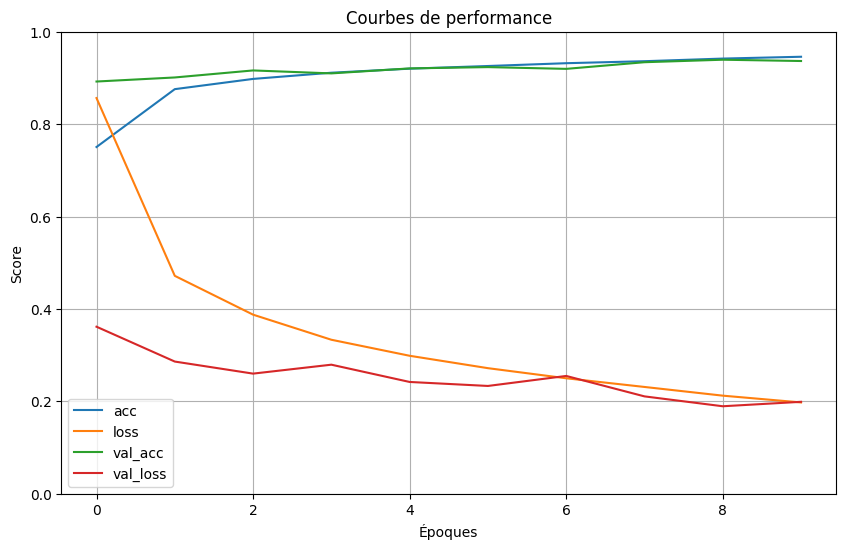

In [11]:

print(history_vgg.epoch)

df_history = pd.DataFrame(history_vgg.history)
plt.figure(figsize=(10, 6))
for col in df_history.columns:
    plt.plot(df_history[col], label=col)

plt.title("Courbes de performance")
plt.xlabel("Époques")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


Le modèle est meilleur que les précédents, il va surajuster si on choisit un nombre d'époques plus  élévé. c'est pourquoi on se limite à 10 époques.

In [12]:
print(f"le score du modèle est : { round(history_vgg.history['val_acc'][8],2)}")

le score du modèle est : 0.94


               Modèle  Performences  Temps(min)   Robustesse
 VGG16 (pré-entraîné)          0.94        14.5 Très robuste
CNN avec Augmentation          0.87         7.5      robuste
CNN sans Augmentation          0.89         4.5    surajuste
      PMC-Keras (MLP)          0.88         2.5        moyen


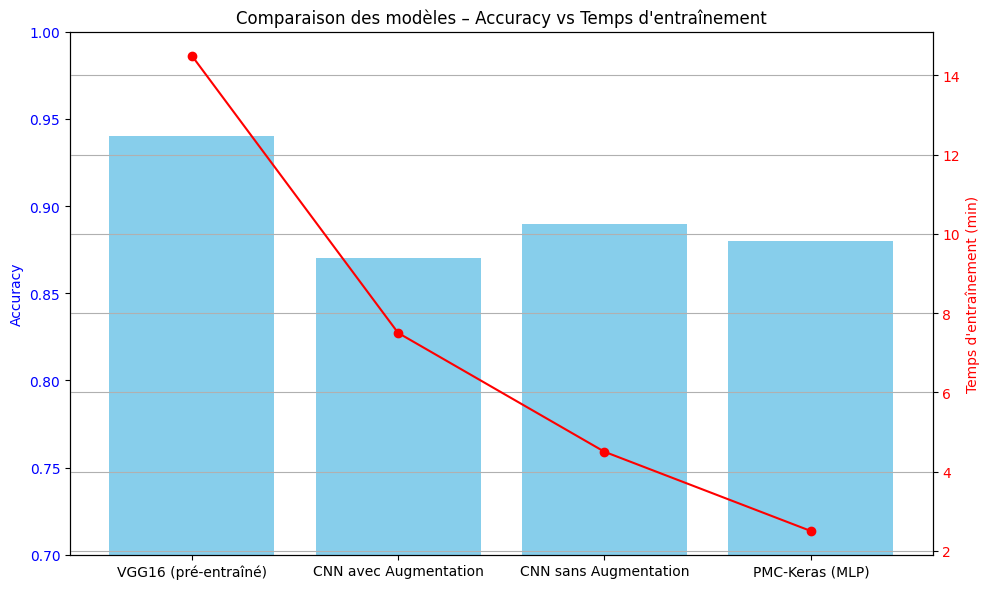

In [4]:
data = {
    "Modèle": [
        "VGG16 (pré-entraîné)",
        "CNN avec Augmentation",
        "CNN sans Augmentation",
        "PMC-Keras (MLP)"
    ],
    "Performences" : [0.94, 0.87, 0.89, 0.88],
    "Temps(min)": [14.5, 7.5, 4.5, 2.5],
    "Robustesse": ["Très robuste", "robuste", "surajuste", "moyen"]
}

df = pd.DataFrame(data)

print(df.to_string(index=False))


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df["Modèle"], df["Performences"], color="skyblue", label="Accuracy (test)")
ax1.set_ylabel("Accuracy", color="blue")
ax1.set_ylim(0.7, 1.0)
ax1.tick_params(axis='y', labelcolor="blue")
ax2 = ax1.twinx()
ax2.plot(df["Modèle"], df["Temps(min)"], color="red", marker="o", label="Temps d'entraînement")
ax2.set_ylabel("Temps d'entraînement (min)", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Comparaison des modèles – Accuracy vs Temps d'entraînement")
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
#Le travail est terminé ici. on libere le GPU pour permettre à d'autre utilisateur de l'utiliser
os.kill(os.getpid(), 9)